In [23]:
import pandas as pd
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from scipy import stats as st

In [24]:
company_data = pd.read_csv('/datasets/project_sql_result_01.csv')
trips_data = pd.read_csv('/datasets/project_sql_result_04.csv')

In [25]:
company_data.info()
print()
print(company_data.head(10))

print()
print(f"El numero de filas duplicadas es: {company_data.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB

                        company_name  trips_amount
0                          Flash Cab         19558
1          Taxi Affiliation Services         11422
2                  Medallion Leasing         10367
3                         Yellow Cab          9888
4    Taxi Affiliation Service Yellow          9299
5          Chicago Carriage Cab Corp          9181
6                       City Service          8448
7                           Sun Taxi          7701
8          Star North Management LLC          7455
9  Blue Ribbon Taxi Association Inc.          5953

El numero de filas duplicadas es: 0



Los tipos de datos son object e int, eso me parece correcto y no hay necesidad de modificarlo.
Los nombres de las columnas tambien se encuentran en el formato correcto.
No existen valores nulos.

In [26]:
trips_data.info()
print()
print(trips_data.head(10))
print()
print(f"El numero de filas duplicadas es: {trips_data.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667

El numero de filas duplicadas es: 0


Los tipos de datos son object y float, eso me parece correcto y no hay necesidad de modificarlo.
Los nombres de las columnas tambien se encuentran en el formato correcto.
No existen valores nulos.

In [27]:
trips_data = trips_data.sort_values(by="average_trips", ascending=False)
print(trips_data.head(10))

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667


<function matplotlib.pyplot.show(close=None, block=None)>

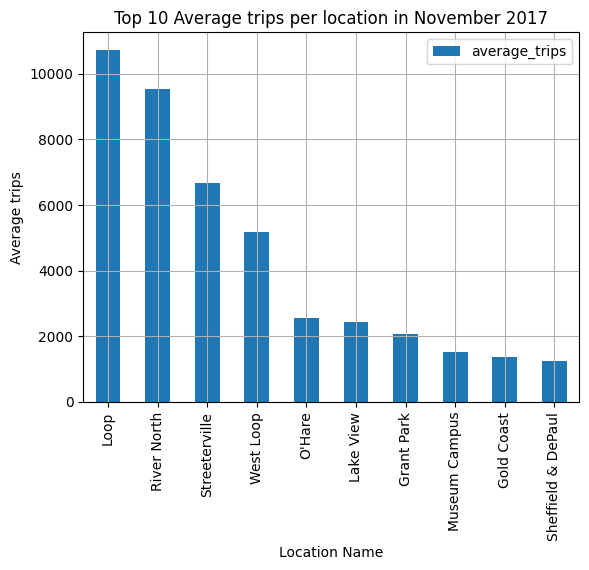

In [28]:
top_10 = trips_data.head(10)

top_10.plot(x="dropoff_location_name",
                y="average_trips",
                title="Top 10 Average trips per location in November 2017",
                xlabel="Location Name",
                ylabel="Average trips",
                kind="bar",
                xlim=[6, 7.5],
                grid=True
               )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

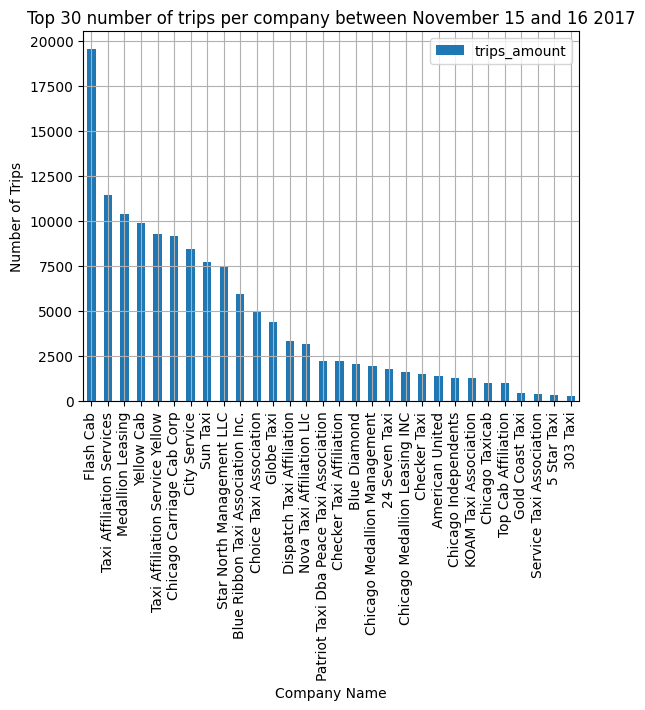

In [29]:
company_data = company_data.sort_values(by="trips_amount", ascending=False)
top_30 = company_data.head(30)
top_30.plot(x="company_name",
                y="trips_amount",
                title="Top 30 number of trips per company between November 15 and 16 2017",
                xlabel="Company Name",
                ylabel="Number of Trips",
                kind="bar",
                grid=True
               )
plt.show

Basado en estos dataset pudimos obtener informacion sobre las 10 colonias mas populares en cuanto a viajes terminados y las 30 compañias con mas viajes terminados.
Si nuestro enfoque toma en cuenta esas 10 colonias podemos esperar una cantidad alta de solicitudes de viaje de parte de los usuarios.
Flash Cab es la compañia mas popular y el numero de viajes es casi el doble de la siguiente compañia mas popular. Podemos aprender mucho analizando la estrategia usada por esa compañia.

In [30]:
loop_data = pd.read_csv('/datasets/project_sql_result_07.csv')

loop_data.info()
print()
print(loop_data.head(10))

print()
print(f"El numero de filas duplicadas es: {loop_data.duplicated().sum()}")
print()
print(loop_data["weather_conditions"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB

              start_ts weather_conditions  duration_seconds
0  2017-11-25 16:00:00               Good            2410.0
1  2017-11-25 14:00:00               Good            1920.0
2  2017-11-25 12:00:00               Good            1543.0
3  2017-11-04 10:00:00               Good            2512.0
4  2017-11-11 07:00:00               Good            1440.0
5  2017-11-11 04:00:00               Good            1320.0
6  2017-11-04 16:00:00                Bad            2969.0
7  2017-11-18 11:00:00               Good            2280.0
8  2017-11-11 14:00:00               Good            24

En este caso tenemos 197 filas duplicadas. Decidi no eliminar estas filas ya que son casi 200 (20% del total) y la duplicidad puede deberse a que la columna start_ts esta redondeada a la hora.

# Prueba de hipotesis

La hipotesis nula es que no hay una diferencia entre la duracion promedio de los viajes 
los sabados lluviosos.

Propongo una prueba de hipótesis de dos colas ya que nos interesa si hay diferencia, 
ya sea menor o mayor.
Propongo un valor alfa de 5% estandar para este tipo de pruebas.

Realizamos prueva de Levene para determinar la igualdad de varianzas:

In [31]:
good_weather_trips = loop_data[loop_data['weather_conditions'] == 'Good']

bad_weather_trips = loop_data[loop_data['weather_conditions'] == 'Bad']

estadistico, p_valor = st.levene(good_weather_trips["duration_seconds"], bad_weather_trips["duration_seconds"])
print(f'Estadístico de Levene: {estadistico}, p-valor: {p_valor}')
print("El valor de p es mayor al valor de alpha, por lo tanto no podemos rechazar la igualdad de varianzas")

Estadístico de Levene: 0.38853489683656073, p-valor: 0.5332038671974493
El valor de p es mayor al valor de alpha, por lo tanto no podemos rechazar la igualdad de varianzas


In [32]:
alpha = 0.05 

results = st.ttest_ind(good_weather_trips['duration_seconds'], bad_weather_trips['duration_seconds'], equal_var=False) 

print()
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 6.738994326108734e-12
Rechazamos la hipótesis nula


# Rechazamos la hipotesis nula.

Si hay una diferencia en la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare los sábados lluviosos.

Este resultado concuerda con la premisa de que al haber mal clima el trafico se incrementara y el tiempo promedio de un viaje sera mayor.

Podemos usar esta informacion para crear campañas de marketing con el proposito de atraer clientes en esos dias de mal clima para incrementar las ganancias, o crear boletines de promociones para atraer mas clientes.